# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: embeddings["<UNK>"] for key, _ in oov_embeddings.items()}

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5271 | MulticlassF1Score=0.0209
Batch-30 : CrossEntropyLoss=2.4958 | MulticlassF1Score=0.1188
Batch-45 : CrossEntropyLoss=2.4707 | MulticlassF1Score=0.1596
Batch-60 : CrossEntropyLoss=2.4860 | MulticlassF1Score=0.1772
Batch-75 : CrossEntropyLoss=2.4752 | MulticlassF1Score=0.1893
Batch-90 : CrossEntropyLoss=2.4929 | MulticlassF1Score=0.1984
Batch-105: CrossEntropyLoss=2.4715 | MulticlassF1Score=0.2043
Batch-120: CrossEntropyLoss=2.4572 | MulticlassF1Score=0.2086
Batch-135: CrossEntropyLoss=2.4529 | MulticlassF1Score=0.2155
Batch-150: CrossEntropyLoss=2.4489 | MulticlassF1Score=0.2268
Batch-165: CrossEntropyLoss=2.4638 | MulticlassF1Score=0.2365
Batch-180: CrossEntropyLoss=2.4414 | MulticlassF1Score=0.2489
Batch-195: CrossEntropyLoss=2.4010 | MulticlassF1Score=0.2654
Batch-210: CrossEntropyLoss=2.3643 | MulticlassF1Score=0.2861
Batch-225: CrossEntropyLoss=2.3513 | MulticlassF1Score=0.3081
Batch-226: CrossEntropyLoss=2.3653 | MulticlassF1Score=0.3091

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3761 | MulticlassF1Score=0.6433
Batch-30 : CrossEntropyLoss=2.3735 | MulticlassF1Score=0.6408
Batch-45 : CrossEntropyLoss=2.3490 | MulticlassF1Score=0.6392
Batch-60 : CrossEntropyLoss=2.3699 | MulticlassF1Score=0.6405
Batch-63 : CrossEntropyLoss=2.3476 | MulticlassF1Score=0.6407

Training   : Mean CrossEntropyLoss = 2.4718 | Mean MulticlassF1Score = 0.1984
Validation : Mean CrossEntropyLoss = 2.3618 | Mean MulticlassF1Score = 0.6422

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3662 | MulticlassF1Score=0.6463
Batch-30 : CrossEntropyLoss=2.3686 | MulticlassF1Score=0.6453
Batch-45 : CrossEntropyLoss=2.3670 | MulticlassF1Score=0.6449
Batch-60 : CrossEntropyLoss=2.3535 | MulticlassF1Score=0.6531
Batch-75 : CrossEntropyLoss=2.3381 | MulticlassF1Score=0.6611
Batch-90 : CrossEntropyLoss=2.3337 | MulticlassF1Score=0.6689
Batch-105: CrossEntropyLoss=2.3519 | MulticlassF1Score=0.6785
Batch-120: CrossEntropyLoss=2.3281 | MulticlassF1Score=0.6854
Batch-135: CrossEntropyLoss=2.3308 | MulticlassF1Score=0.6915
Batch-150: CrossEntropyLoss=2.3213 | MulticlassF1Score=0.6995
Batch-165: CrossEntropyLoss=2.3239 | MulticlassF1Score=0.7054
Batch-180: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7104
Batch-195: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7146
Batch-210: CrossEntropyLoss=2.3270 | MulticlassF1Score=0.7185
Batch-225: CrossEntropyLoss=2.3272 | MulticlassF1Score=0.7221
Batch-226: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7222

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7730
Batch-30 : CrossEntropyLoss=2.3236 | MulticlassF1Score=0.7713
Batch-45 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.7704
Batch-60 : CrossEntropyLoss=2.3323 | MulticlassF1Score=0.7698
Batch-63 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7697

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3351 | Mean MulticlassF1Score = 0.6807
Validation : Mean CrossEntropyLoss = 2.3199 | Mean MulticlassF1Score = 0.7710

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7772
Batch-30 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7838
Batch-45 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7864
Batch-60 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7882
Batch-75 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7878
Batch-90 : CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7865
Batch-105: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7856
Batch-120: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7864
Batch-135: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7880
Batch-150: CrossEntropyLoss=2.3209 | MulticlassF1Score=0.7886
Batch-165: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.7889
Batch-180: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7897
Batch-195: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7911
Batch-210: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7920
Batch-225: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7927
Batch-226: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.7928

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8084
Batch-30 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8064
Batch-45 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8063
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8065
Batch-63 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8062

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3124 | Mean MulticlassF1Score = 0.7864
Validation : Mean CrossEntropyLoss = 2.3084 | Mean MulticlassF1Score = 0.8056

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8134
Batch-30 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8133
Batch-45 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8135
Batch-60 : CrossEntropyLoss=2.3200 | MulticlassF1Score=0.8110
Batch-75 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8114
Batch-90 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8124
Batch-105: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8116
Batch-120: CrossEntropyLoss=2.3347 | MulticlassF1Score=0.8105
Batch-135: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8099
Batch-150: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8102
Batch-165: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8101
Batch-180: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8106
Batch-195: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8112
Batch-210: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8108
Batch-225: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8110
Batch-226: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8110

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8147
Batch-30 : CrossEntropyLoss=2.3150 | MulticlassF1Score=0.8155
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8160
Batch-60 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8128
Batch-63 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8129

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3074 | Mean MulticlassF1Score = 0.8118
Validation : Mean CrossEntropyLoss = 2.3065 | Mean MulticlassF1Score = 0.8143

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8140
Batch-30 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8164
Batch-45 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8158
Batch-60 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8166
Batch-75 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8153
Batch-90 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8164
Batch-105: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8174
Batch-120: CrossEntropyLoss=2.3127 | MulticlassF1Score=0.8166
Batch-135: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8164
Batch-150: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8160
Batch-165: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.8161
Batch-180: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8165
Batch-195: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8168
Batch-210: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8170
Batch-225: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8173
Batch-226: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8173

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8189
Batch-30 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.8128
Batch-45 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8139
Batch-60 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8143
Batch-63 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8158

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3046 | Mean MulticlassF1Score = 0.8161
Validation : Mean CrossEntropyLoss = 2.3049 | Mean MulticlassF1Score = 0.8165

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8224
Batch-30 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8254
Batch-45 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8227
Batch-60 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8205
Batch-75 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8193
Batch-90 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8193
Batch-105: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8202
Batch-120: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8204
Batch-135: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8212
Batch-150: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8209
Batch-165: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8213
Batch-180: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8213
Batch-195: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8221
Batch-210: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8220
Batch-225: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8223
Batch-226: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8222

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8297
Batch-30 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8274
Batch-45 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8261
Batch-60 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8253
Batch-63 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3029 | Mean MulticlassF1Score = 0.8220
Validation : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8274

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8281
Batch-30 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8300
Batch-45 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8312
Batch-60 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.8304
Batch-75 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8299
Batch-90 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8294
Batch-105: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8288
Batch-120: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8283
Batch-135: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8294
Batch-150: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8292
Batch-165: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8302
Batch-180: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8305
Batch-195: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8305
Batch-210: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8304
Batch-225: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8304
Batch-226: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8305

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8260
Batch-30 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8257
Batch-45 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.8268
Batch-60 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8252
Batch-63 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8298
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8271

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8399
Batch-30 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8364
Batch-45 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8335
Batch-60 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8333
Batch-75 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8324
Batch-90 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8318
Batch-105: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8323
Batch-120: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8326
Batch-135: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8325
Batch-150: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8324
Batch-165: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8324
Batch-180: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8321
Batch-195: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8320
Batch-210: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8322
Batch-225: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8323
Batch-226: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8324

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8305
Batch-30 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8293
Batch-45 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8273
Batch-60 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8271
Batch-63 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8337
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8298

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8362
Batch-30 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8365
Batch-45 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8410
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8442
Batch-75 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8469
Batch-90 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8495
Batch-105: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8516
Batch-120: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8518
Batch-135: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8530
Batch-150: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8532
Batch-165: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8545
Batch-180: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8566
Batch-195: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8579
Batch-210: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8592
Batch-225: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8603
Batch-226: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8603

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8718
Batch-30 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8729
Batch-45 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8719
Batch-60 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8713
Batch-63 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8708

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2913 | Mean MulticlassF1Score = 0.8499
Validation : Mean CrossEntropyLoss = 2.2884 | Mean MulticlassF1Score = 0.8717

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8788
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8765
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8770
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8766
Batch-75 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8777
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8787
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8799
Batch-120: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8803
Batch-135: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8806
Batch-150: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8807
Batch-165: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8804
Batch-180: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8801
Batch-195: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8800
Batch-210: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8800
Batch-225: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8803
Batch-226: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8803

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8750
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8728
Batch-45 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8757
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8739
Batch-63 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8742

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8793
Validation : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8732

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8787
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8814
Batch-45 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8817
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8830
Batch-75 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8840
Batch-90 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8848
Batch-105: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8846
Batch-120: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8846
Batch-135: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8839
Batch-150: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8840
Batch-165: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8838
Batch-180: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8837
Batch-195: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8834
Batch-210: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8833
Batch-225: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8833
Batch-226: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8833

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8771
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8747
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8754
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8756
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8755

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8829
Validation : Mean CrossEntropyLoss = 2.2866 | Mean MulticlassF1Score = 0.8752

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8856
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8869
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8865
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8840
Batch-75 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8842
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8848
Batch-105: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8849
Batch-120: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8856
Batch-135: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8852
Batch-150: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8853
Batch-165: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8852
Batch-180: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8854
Batch-195: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8857
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8856
Batch-225: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8854
Batch-226: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8854

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8769
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8800
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8773
Batch-60 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8762
Batch-63 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8763

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8851
Validation : Mean CrossEntropyLoss = 2.2863 | Mean MulticlassF1Score = 0.8776

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8859
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8890
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8884
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8886
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8892
Batch-90 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8886
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8885
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8882
Batch-135: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8881
Batch-150: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8877
Batch-165: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8876
Batch-180: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8871
Batch-195: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8871
Batch-210: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8874
Batch-225: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8872
Batch-226: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8872

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8772
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8777
Batch-45 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8767
Batch-60 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8764
Batch-63 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8763

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8876
Validation : Mean CrossEntropyLoss = 2.2862 | Mean MulticlassF1Score = 0.8779

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8912
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8904
Batch-60 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8901
Batch-75 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8891
Batch-90 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8887
Batch-105: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8884
Batch-120: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8878
Batch-135: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8880
Batch-150: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8883
Batch-165: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8884
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8882
Batch-195: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8884
Batch-210: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8885
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8884
Batch-226: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8885

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8723
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8727
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8760
Batch-60 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8766
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8763

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8891
Validation : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8734

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8926
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8912
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8896
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8908
Batch-75 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8907
Batch-90 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8905
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8899
Batch-120: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8899
Batch-135: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8897
Batch-150: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8895
Batch-165: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8899
Batch-180: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8899
Batch-195: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8897
Batch-210: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8898
Batch-225: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8898
Batch-226: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8898

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8770
Batch-30 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8770
Batch-45 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8782
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8780
Batch-63 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8773

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8906
Validation : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8781

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8893
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8875
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8881
Batch-75 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8880
Batch-90 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8890
Batch-105: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8894
Batch-120: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8898
Batch-135: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8896
Batch-150: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8894
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8900
Batch-180: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8903
Batch-195: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8908
Batch-210: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8908
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8908
Batch-226: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8908

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8782
Batch-30 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8766
Batch-45 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8753
Batch-60 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8757
Batch-63 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8760

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8892
Validation : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8770

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8904
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8916
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8932
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8937
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8939
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8928
Batch-105: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8926
Batch-120: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8929
Batch-135: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8929
Batch-150: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8930
Batch-165: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8928
Batch-180: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8929
Batch-195: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8925
Batch-210: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8921
Batch-225: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8917
Batch-226: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8916

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8797
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8778
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8783
Batch-60 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8774
Batch-63 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8772

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8927
Validation : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8795

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8953
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8928
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8926
Batch-60 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8930
Batch-75 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8927
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8926
Batch-105: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8925
Batch-120: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8928
Batch-135: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8931
Batch-150: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8927
Batch-165: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8928
Batch-180: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8928
Batch-195: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8926
Batch-210: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8924
Batch-225: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8926
Batch-226: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8926

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8784
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8774
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8759
Batch-60 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8776
Batch-63 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8772

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8929
Validation : Mean CrossEntropyLoss = 2.2857 | Mean MulticlassF1Score = 0.8785

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8943
Batch-30 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8952
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8956
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8948
Batch-75 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8942
Batch-90 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8945
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8945
Batch-120: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8941
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8939
Batch-150: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8934
Batch-165: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8936
Batch-180: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8934
Batch-195: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8933
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8932
Batch-225: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8932
Batch-226: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8767
Batch-30 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8801
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8810
Batch-60 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8800
Batch-63 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8803

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2806 | Mean MulticlassF1Score = 0.8943
Validation : Mean CrossEntropyLoss = 2.2848 | Mean MulticlassF1Score = 0.8806

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8951
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8967
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8974
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8975
Batch-90 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8996
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9028
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9052
Batch-135: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9072
Batch-150: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9085
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9097
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9109
Batch-195: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9118
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9124
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9132
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9133

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9070
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9061
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9059
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9063
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9071

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9035
Validation : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9062

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9259
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9249
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9247
Batch-105: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9248
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9248
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9246
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9245
Batch-165: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9246
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9248
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9249
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9249
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9246
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9247

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9119
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9071
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9055
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9063
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9061

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9249
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9081

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9257
Batch-75 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9251
Batch-90 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9252
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9258
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9257
Batch-135: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9257
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9256
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9254
Batch-180: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9252
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9250
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9253
Batch-225: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9253
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9254

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9038
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9049
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9052
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9069
Batch-63 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9073

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9252
Validation : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9059

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9268
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9263
Batch-90 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9266
Batch-105: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9263
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9267
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9269
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9271
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9270
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9271
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9273
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9275
Batch-225: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9275
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9275

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9120
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9118
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9120
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9124
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9123

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9263
Validation : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9116

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9315
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9326
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9322
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9312
Batch-105: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9317
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9323
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9324
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9322
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9321
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9320
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9315
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9315
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9316
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9316

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9145
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9151
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9142
Batch-63 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9141

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9317
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9151

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9322
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9322
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9333
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9336
Batch-120: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9332
Batch-135: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9332
Batch-150: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9333
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9333
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9335
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9335
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9335
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9333
Batch-226: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9333

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9135
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.9143
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9148
Batch-63 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9145

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9336
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9142

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9333
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9359
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9360
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9360
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9354
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9354
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9349
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9346
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9344
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9345
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9342
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9342
Batch-210: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9339
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9339

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9133
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9144
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9147
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9145

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9348
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9147

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9350
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9351
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9348
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9349
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9354
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9351
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9357
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9358
Batch-150: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9360
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9361
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9359
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9354
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9355
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9355

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9134
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9162
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9152
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9159
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9158

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9352
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9163

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9364
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9362
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9361
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9361
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9363
Batch-120: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9363
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9365
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9368
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9367
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9365
Batch-210: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9365
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9365
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9169
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9178
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9173
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9174

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9175

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9380
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9378
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9376
Batch-105: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9373
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9377
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9376
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9378
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9379
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9144
Batch-30 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9152
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9163
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9174
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9176

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9379
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9151

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9373
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9380
Batch-90 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9386
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9387
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9389
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9389
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9386
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9387
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9188
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9199
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9179
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9178

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9385
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9195

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9386
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9392
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9389
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9385
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9385
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9387
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9387
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9388
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9388

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9188
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9183
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9182

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9179

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9409
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9395
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9396
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9398
Batch-150: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9397
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9398
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9397
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9394
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9152
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9168
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9183
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9186

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9183

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9366
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9398
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9424
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9474
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9492
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9501
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9509
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9514
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9516
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9516

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9392
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9370
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9372

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9385

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9560
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9588
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9592
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9586
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9585
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9591
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9592
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9595
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9590
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9594
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9592
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9592
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9590
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9591
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9591
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9591

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9319
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9360
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9368
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9586
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9355

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9571
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9586
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9586
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9587
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9586
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9589
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9591
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9592
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9598
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9598
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9600
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9597
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9600
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9600
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9598
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9373
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9381
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9382

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9592
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9395

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9590
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9593
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9606
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9606
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9611
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9612
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9610
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9611
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9612
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9610
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9608
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9609
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9609
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9609
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9610

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9379
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9382

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9606
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9383

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9589
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9593
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9604
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9604
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9607
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9610
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9610
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9610
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9611
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9613
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9610
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9611
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9611
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9611

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9383
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9394
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9379
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9382

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9607
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9388

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9612
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9619
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9619
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9620
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9621
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9621
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9615
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9613
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9615
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9613
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9612
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9612
Batch-195: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9612
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9611

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9384
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9384

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9615
Validation : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9390

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9600
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9611
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9631
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9623
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9624
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9626
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9622
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9623
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9620
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9619
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9617
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9618
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9618
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9617
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9617

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9400
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9385
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9382

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9617
Validation : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9395

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9629
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9614
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9627
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9628
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9631
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9628
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9627
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9625
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9625
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9627
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9625
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9623
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9624
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9622
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9620
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9620

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9390
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9386
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9383

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9625
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9393

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9604
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9614
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9609
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9617
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9616
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9616
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9614
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9615
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9615
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9620
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9624
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9622
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9623
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9364
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9377
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9379

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9615
Validation : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9375

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9606
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9619
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9616
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9613
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9617
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9618
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9620
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9623
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9625
Batch-165: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9626
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9626
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9626
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9626
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9626

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9379
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9381
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9380

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9620
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9374

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9615
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9625
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9628
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9630
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9634
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9635
Batch-105: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9638
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9637
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9633
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9631
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9627
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9626
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9625
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9391
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9390

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9629
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9411
Patience = 1/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9644
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9639
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9630
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9638
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9637
Batch-105: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9642
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9639
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9637
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9635
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9636
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9635
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9634
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9635
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9635

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9365
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9371
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9385
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9389

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9638
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9370

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9631
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9649
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9640
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9639
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9639
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9640
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9641
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9642
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9641
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9641
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9641

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9368
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9386
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9389
Batch-63 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9391

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9372

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9653
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9645
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9645
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9648
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9645
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9644
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9644
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9643
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9637

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9399
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9396
Batch-63 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9395

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9644
Validation : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9392
Patience = 2/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9643
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9639
Batch-75 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9640
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9640
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9640
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9644
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9643
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9639
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9639
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9638

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9398
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9399

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9642
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9416

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9651
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9647
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9643
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9639
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9638
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9637
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9637
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9643
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9644
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9392
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9389
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9393

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9645
Validation : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9386

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9648
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9649
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9653
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9654
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9653
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9652
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9648
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9394
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9396

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9649
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9403

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9630
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9640
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9651
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9649
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9647
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9646
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9649
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9647
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9401
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9398

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9647
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9436

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2583
Best CrossEntropyLoss training    : 2.2662
Best MulticlassF1Score validation : 0.9647
Best MulticlassF1Score validation : 0.9436
Training duration                 : 1.9917 minutes.
Training date                     : 2022-10-24 19:04:59.064440+08:00


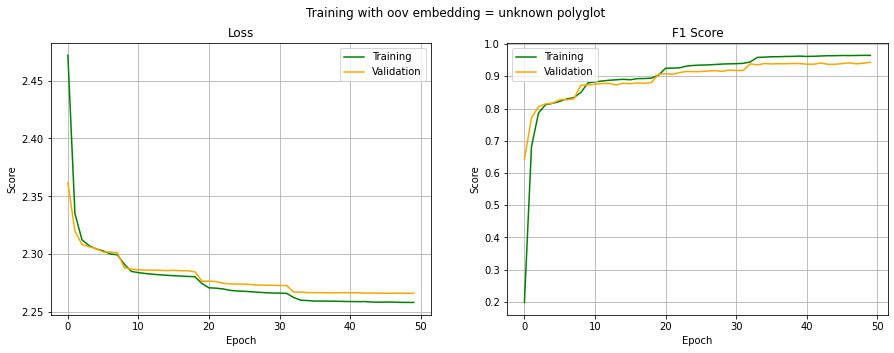

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/unk/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = unknown polyglot")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9653, device='cuda:0'),
 tensor(0.9398, device='cuda:0'),
 tensor(0.9376, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9653, device='cuda:0'),
 tensor(0.9398, device='cuda:0'),
 tensor(0.9376, device='cuda:0'))

## Heatmap

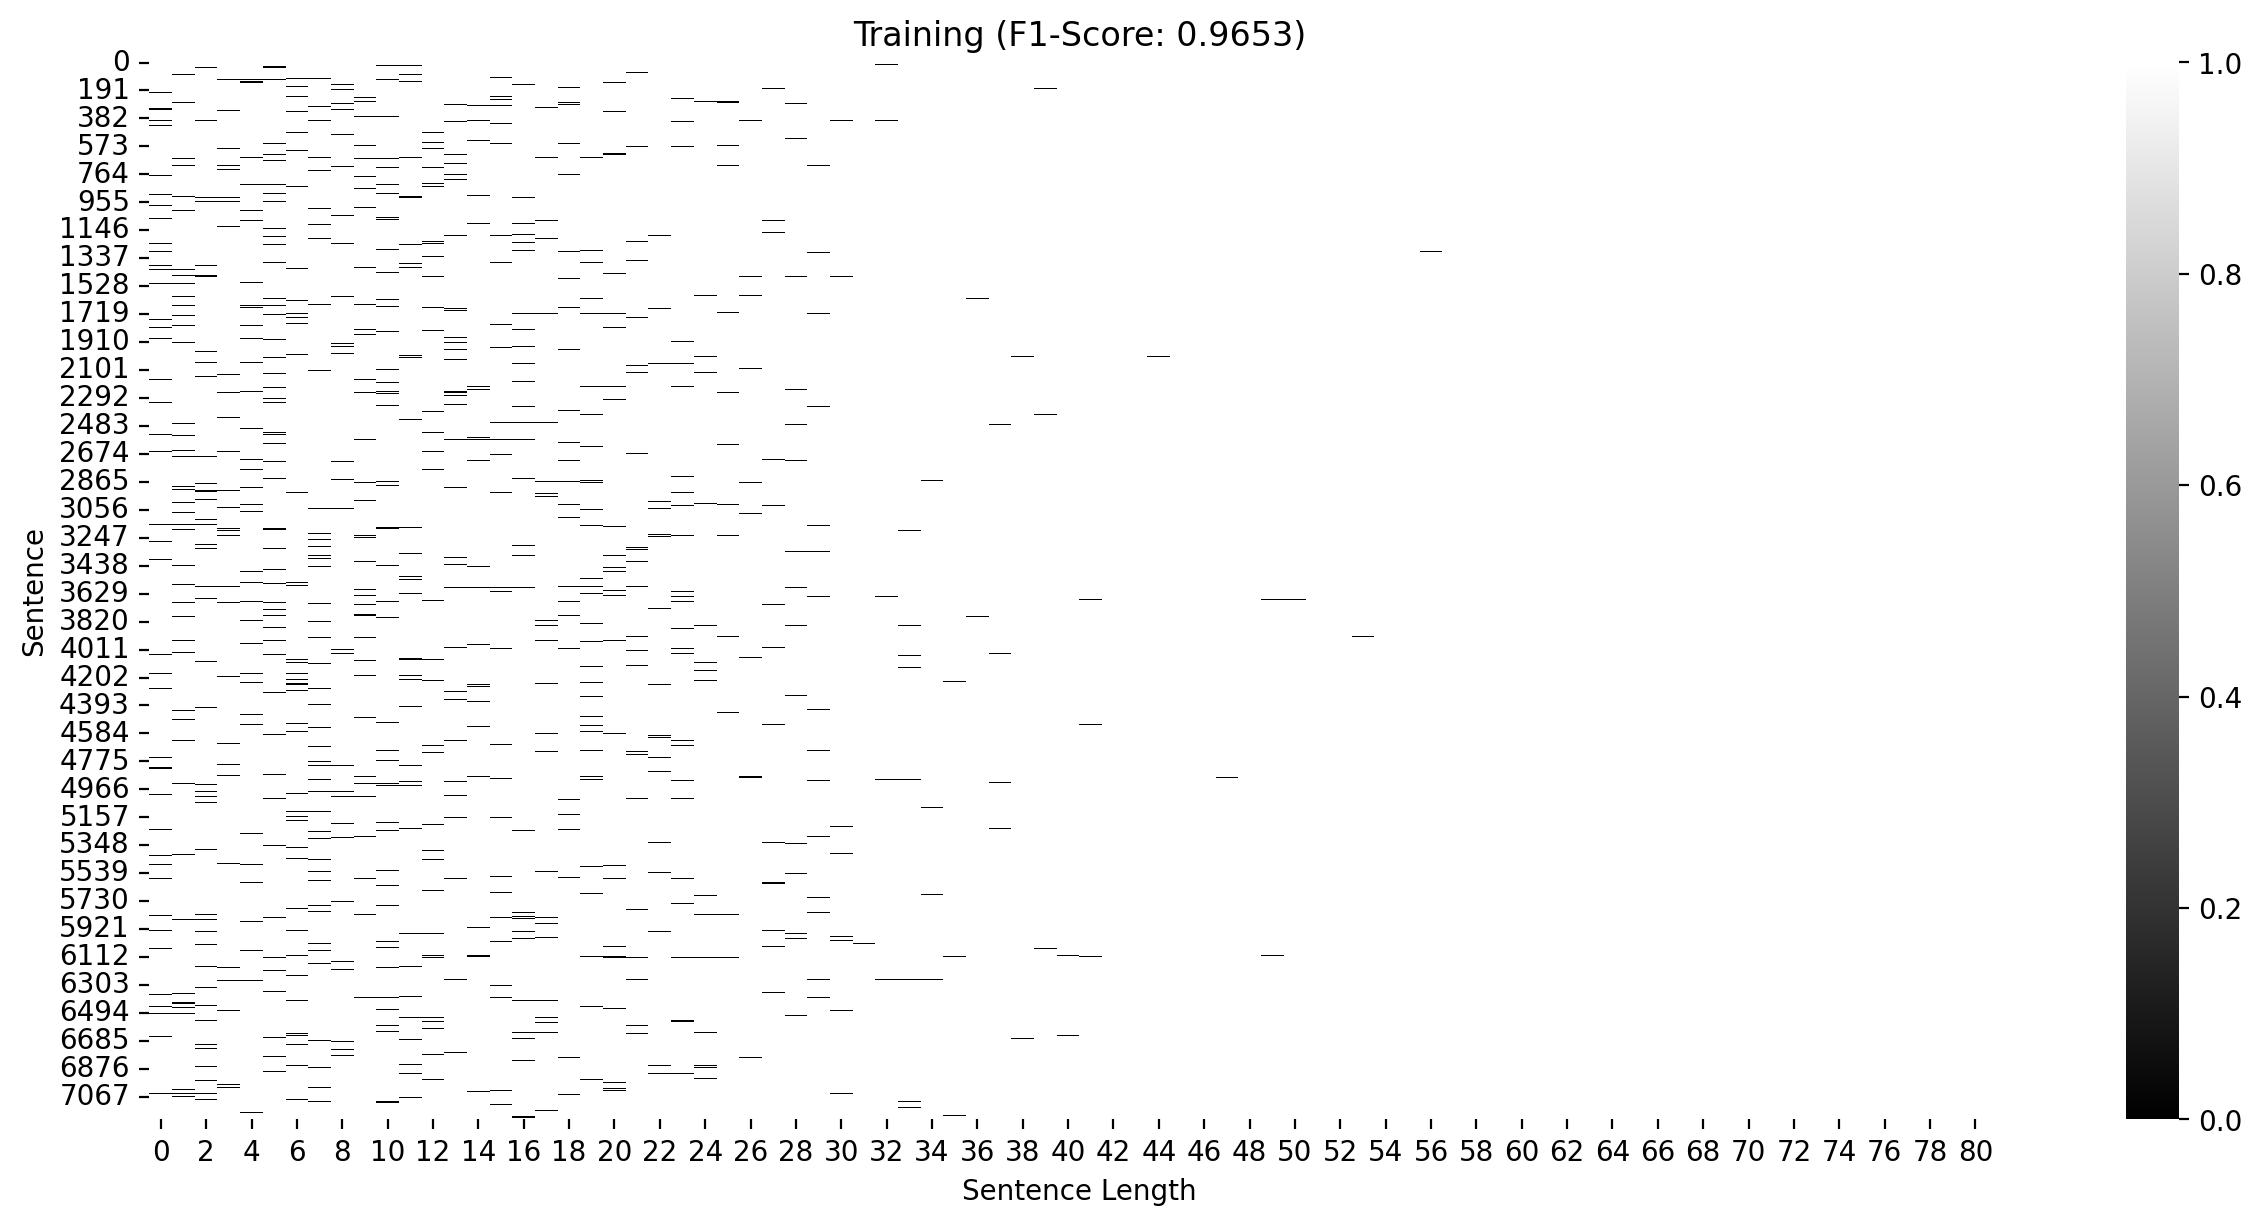

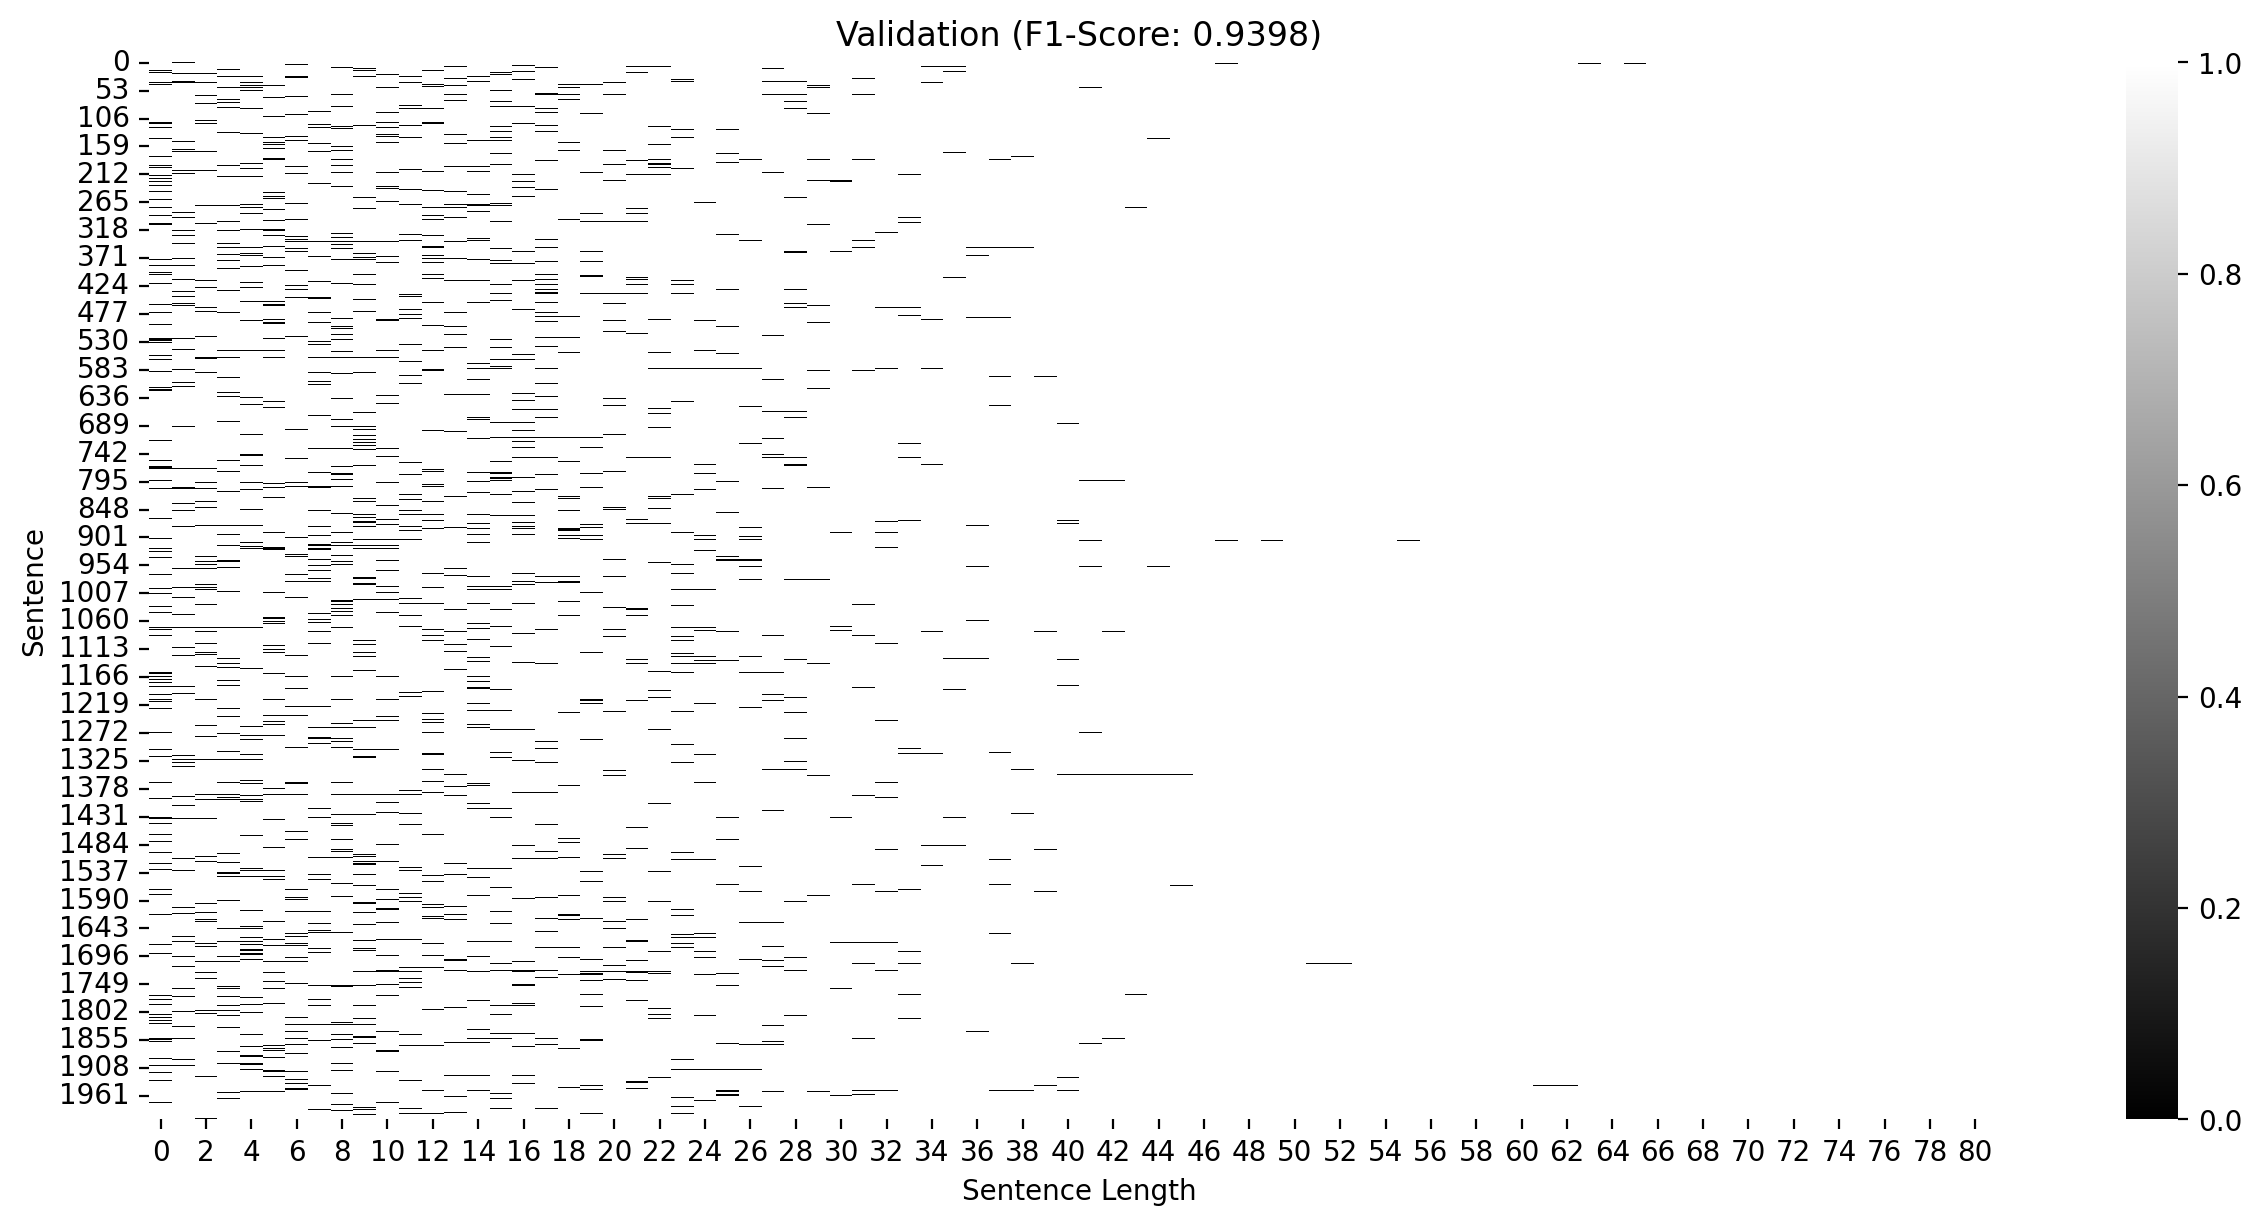

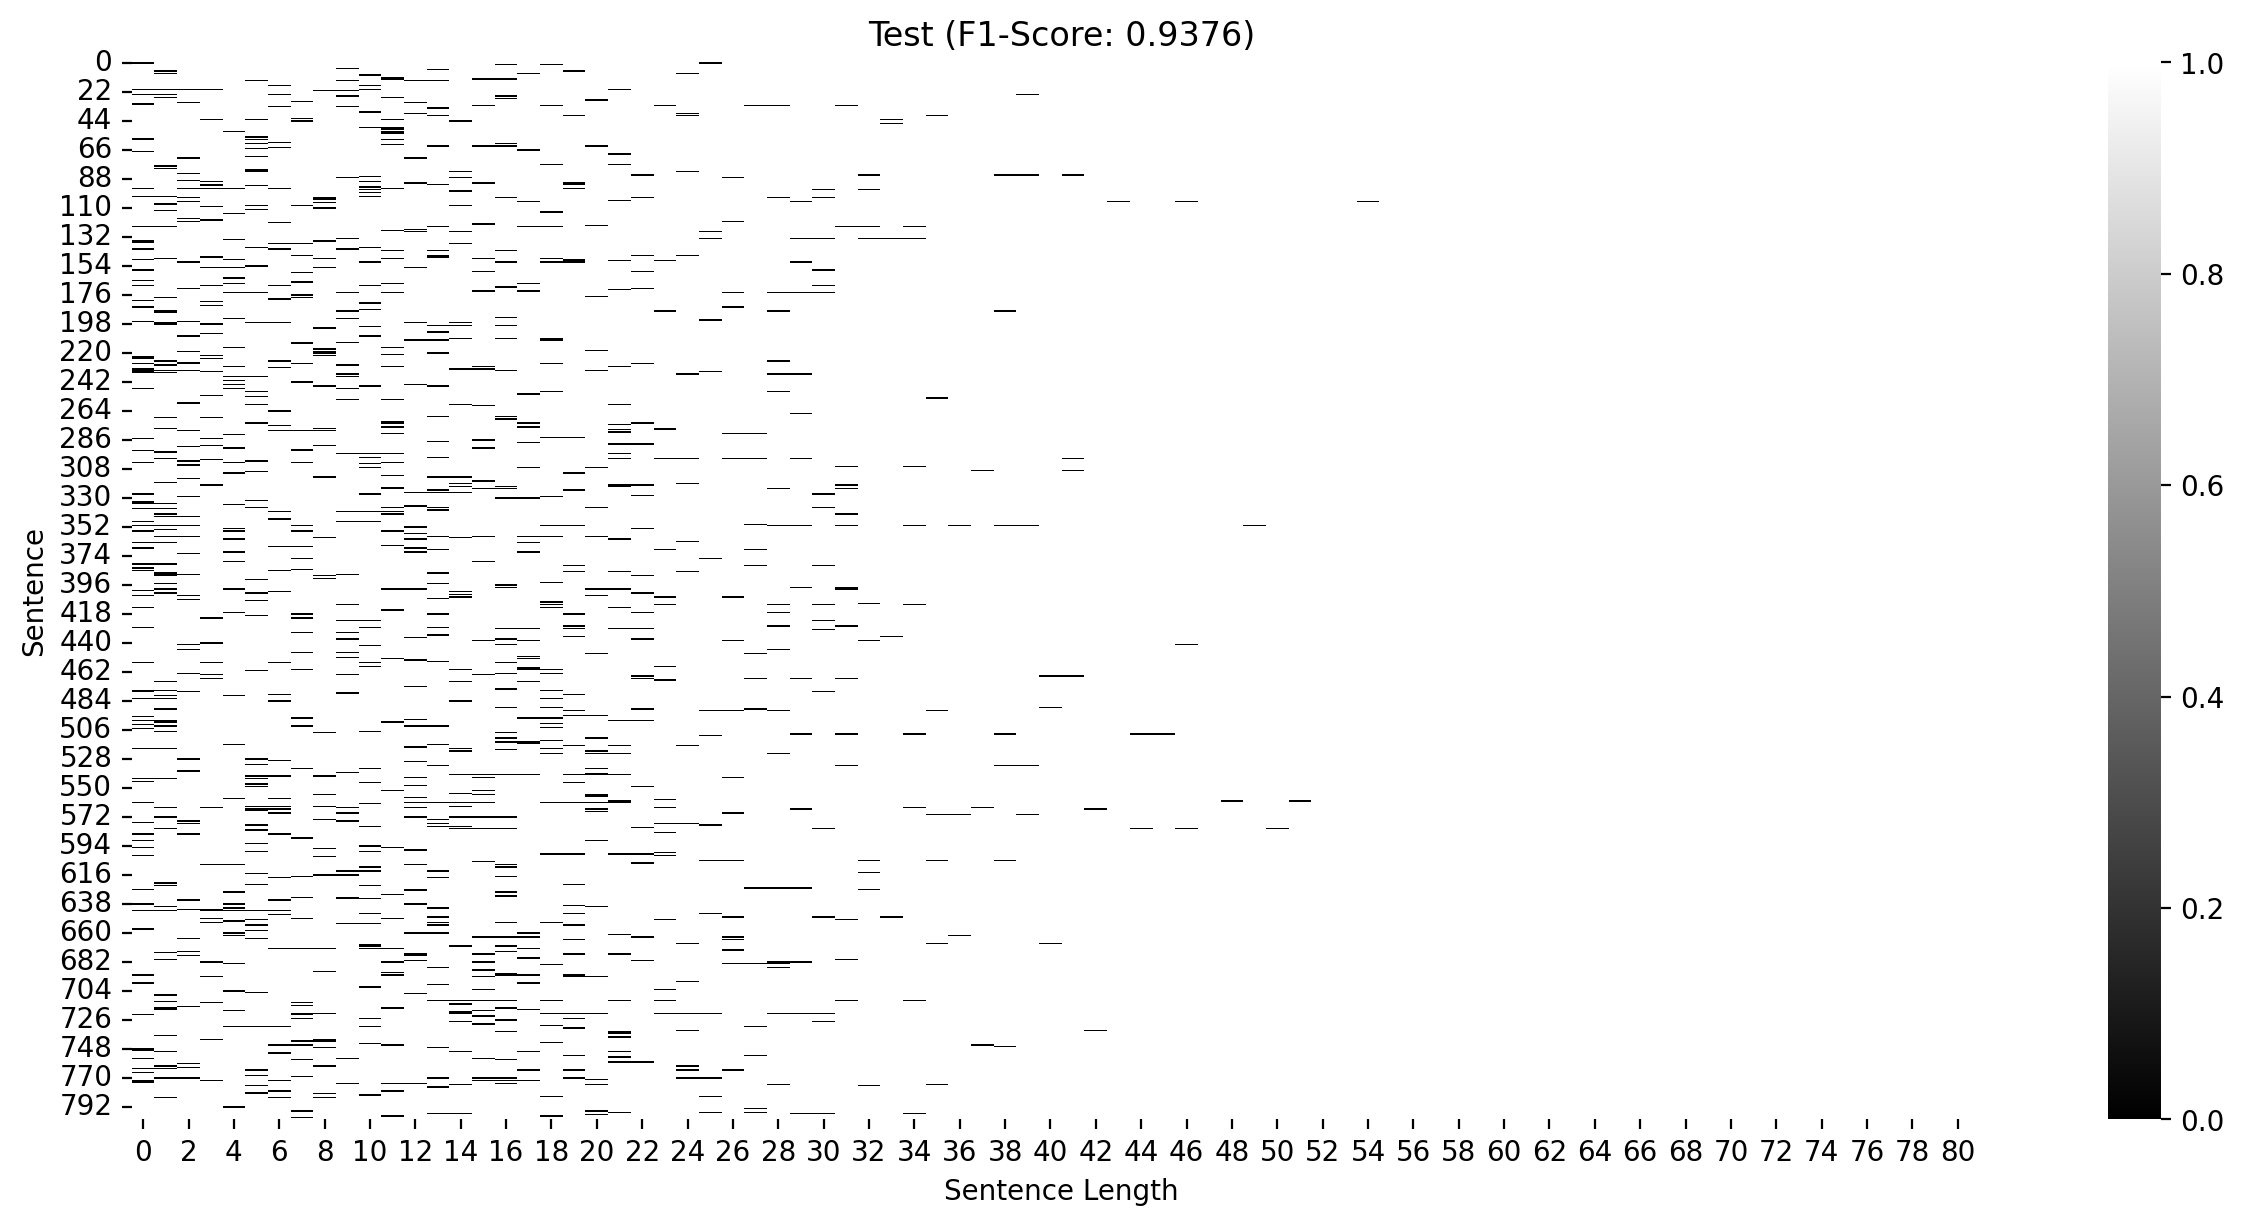

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


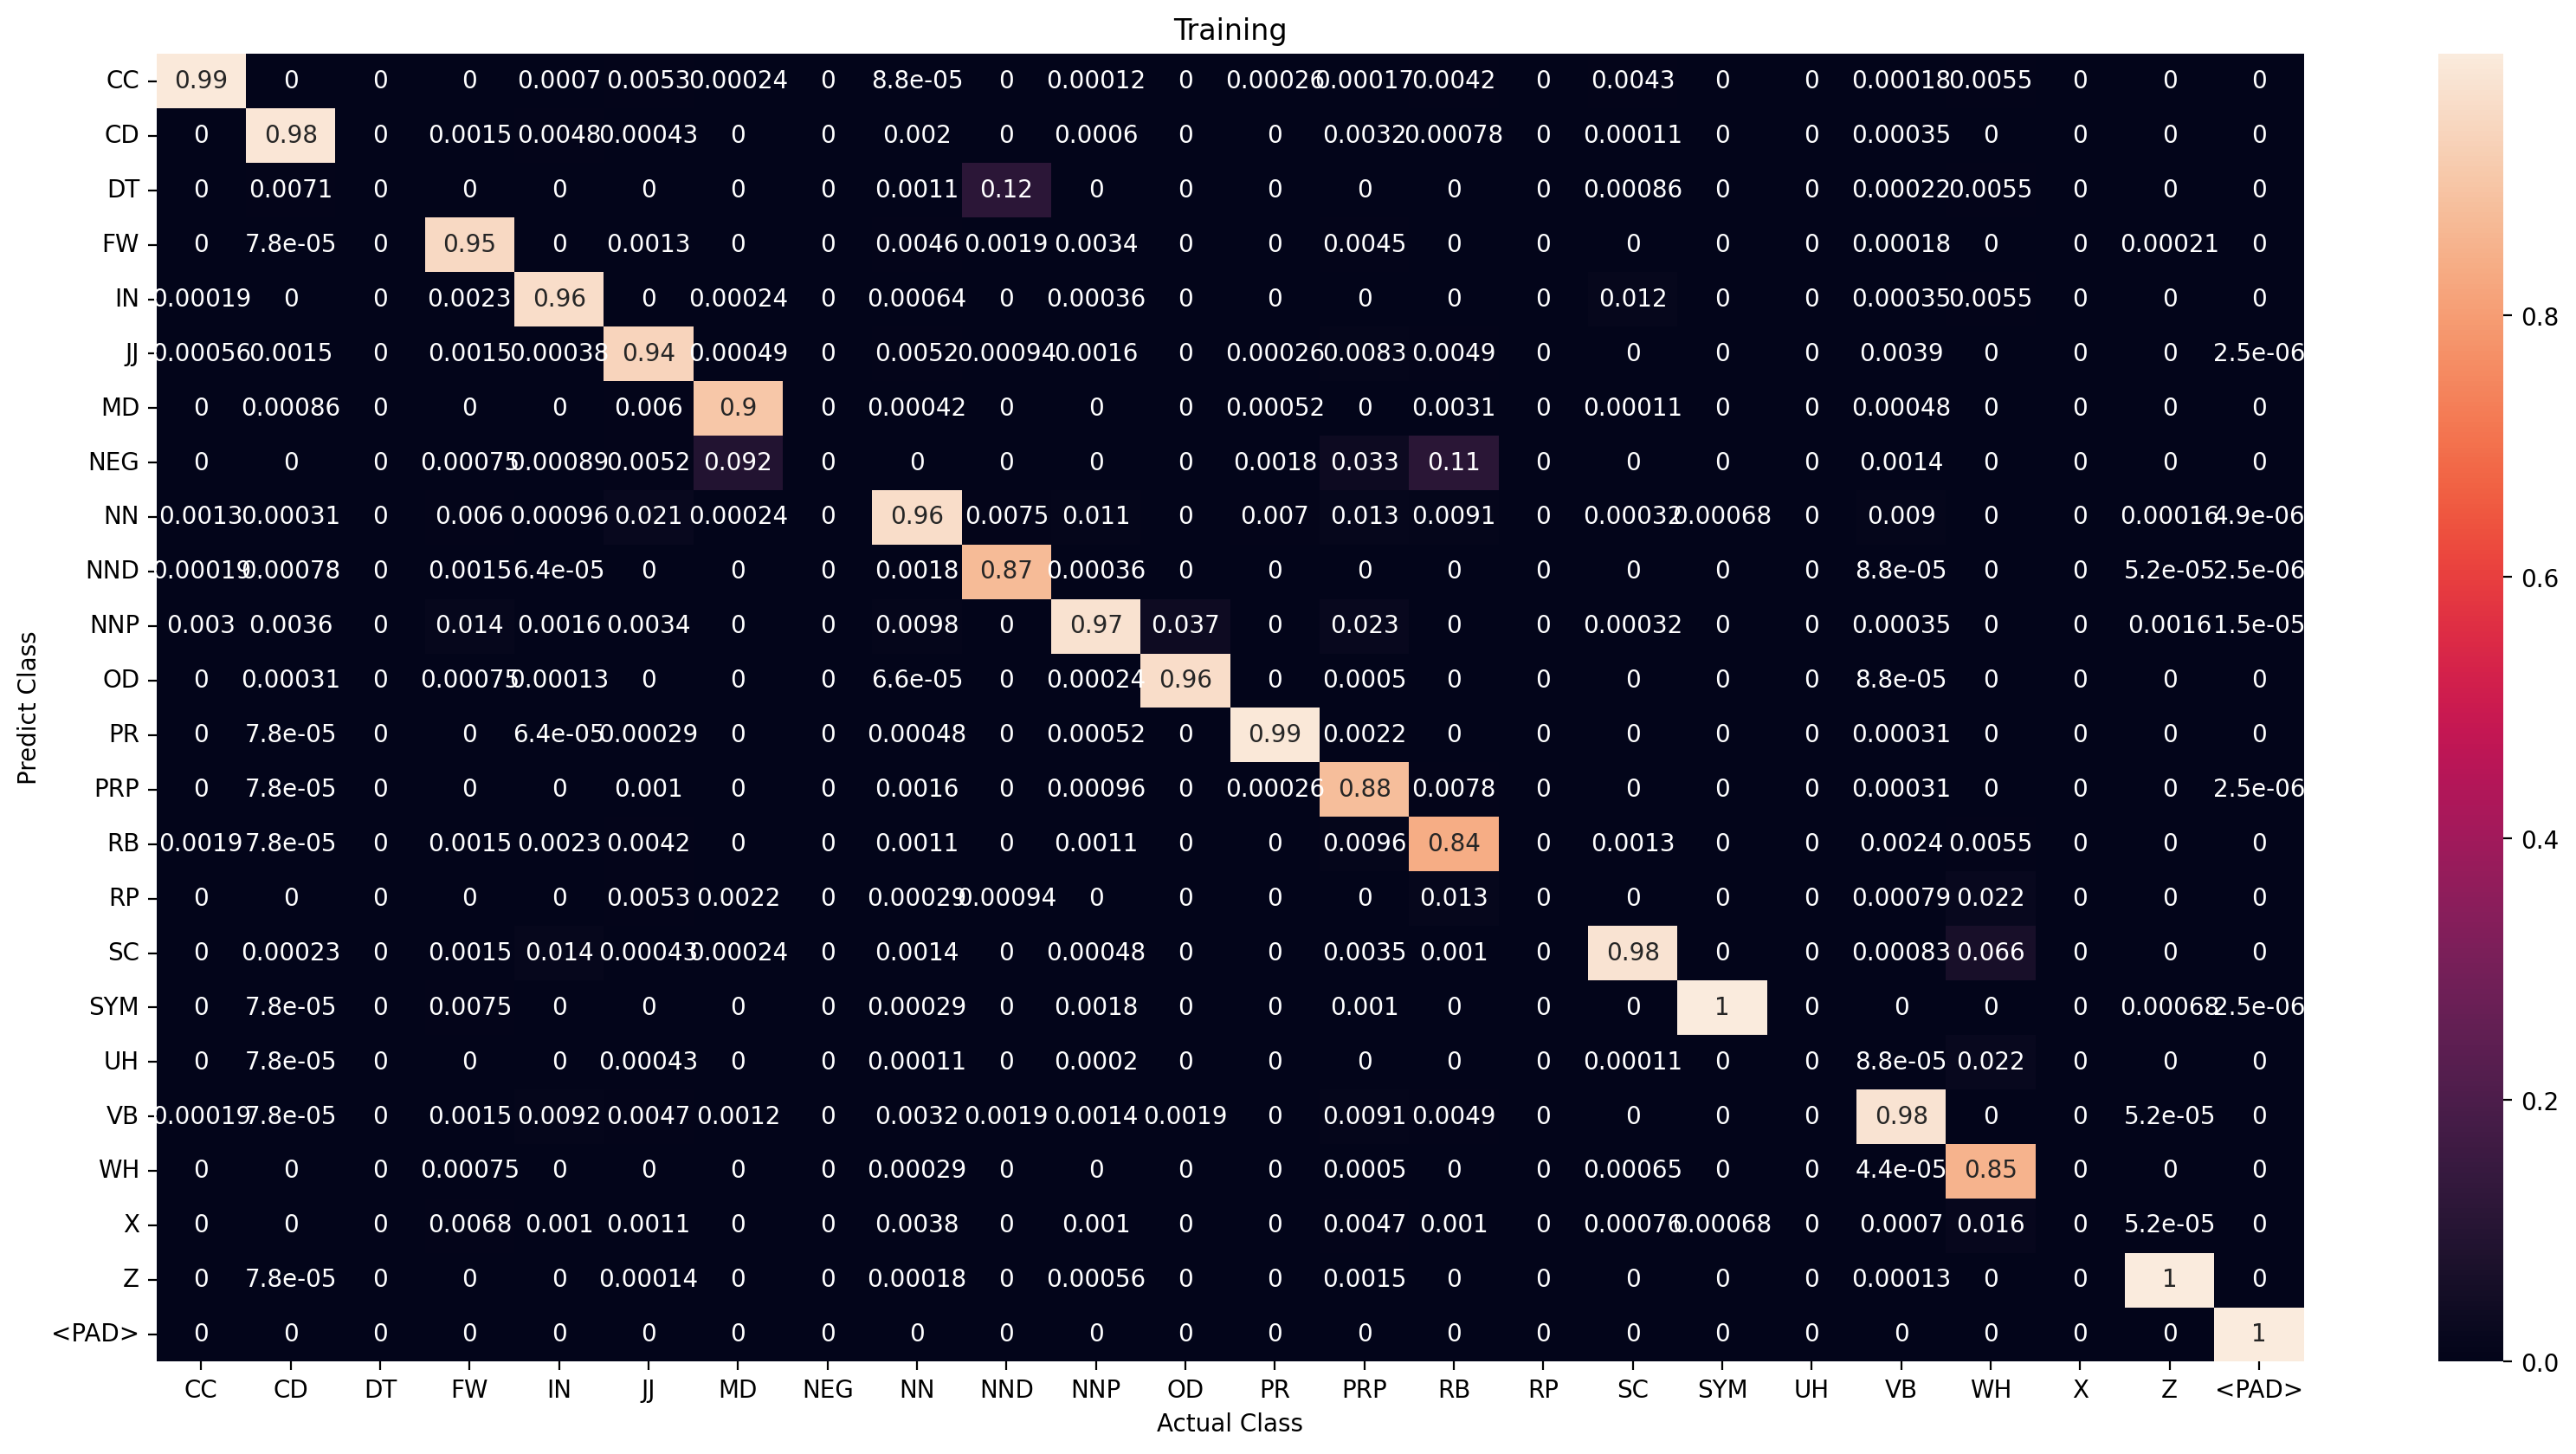

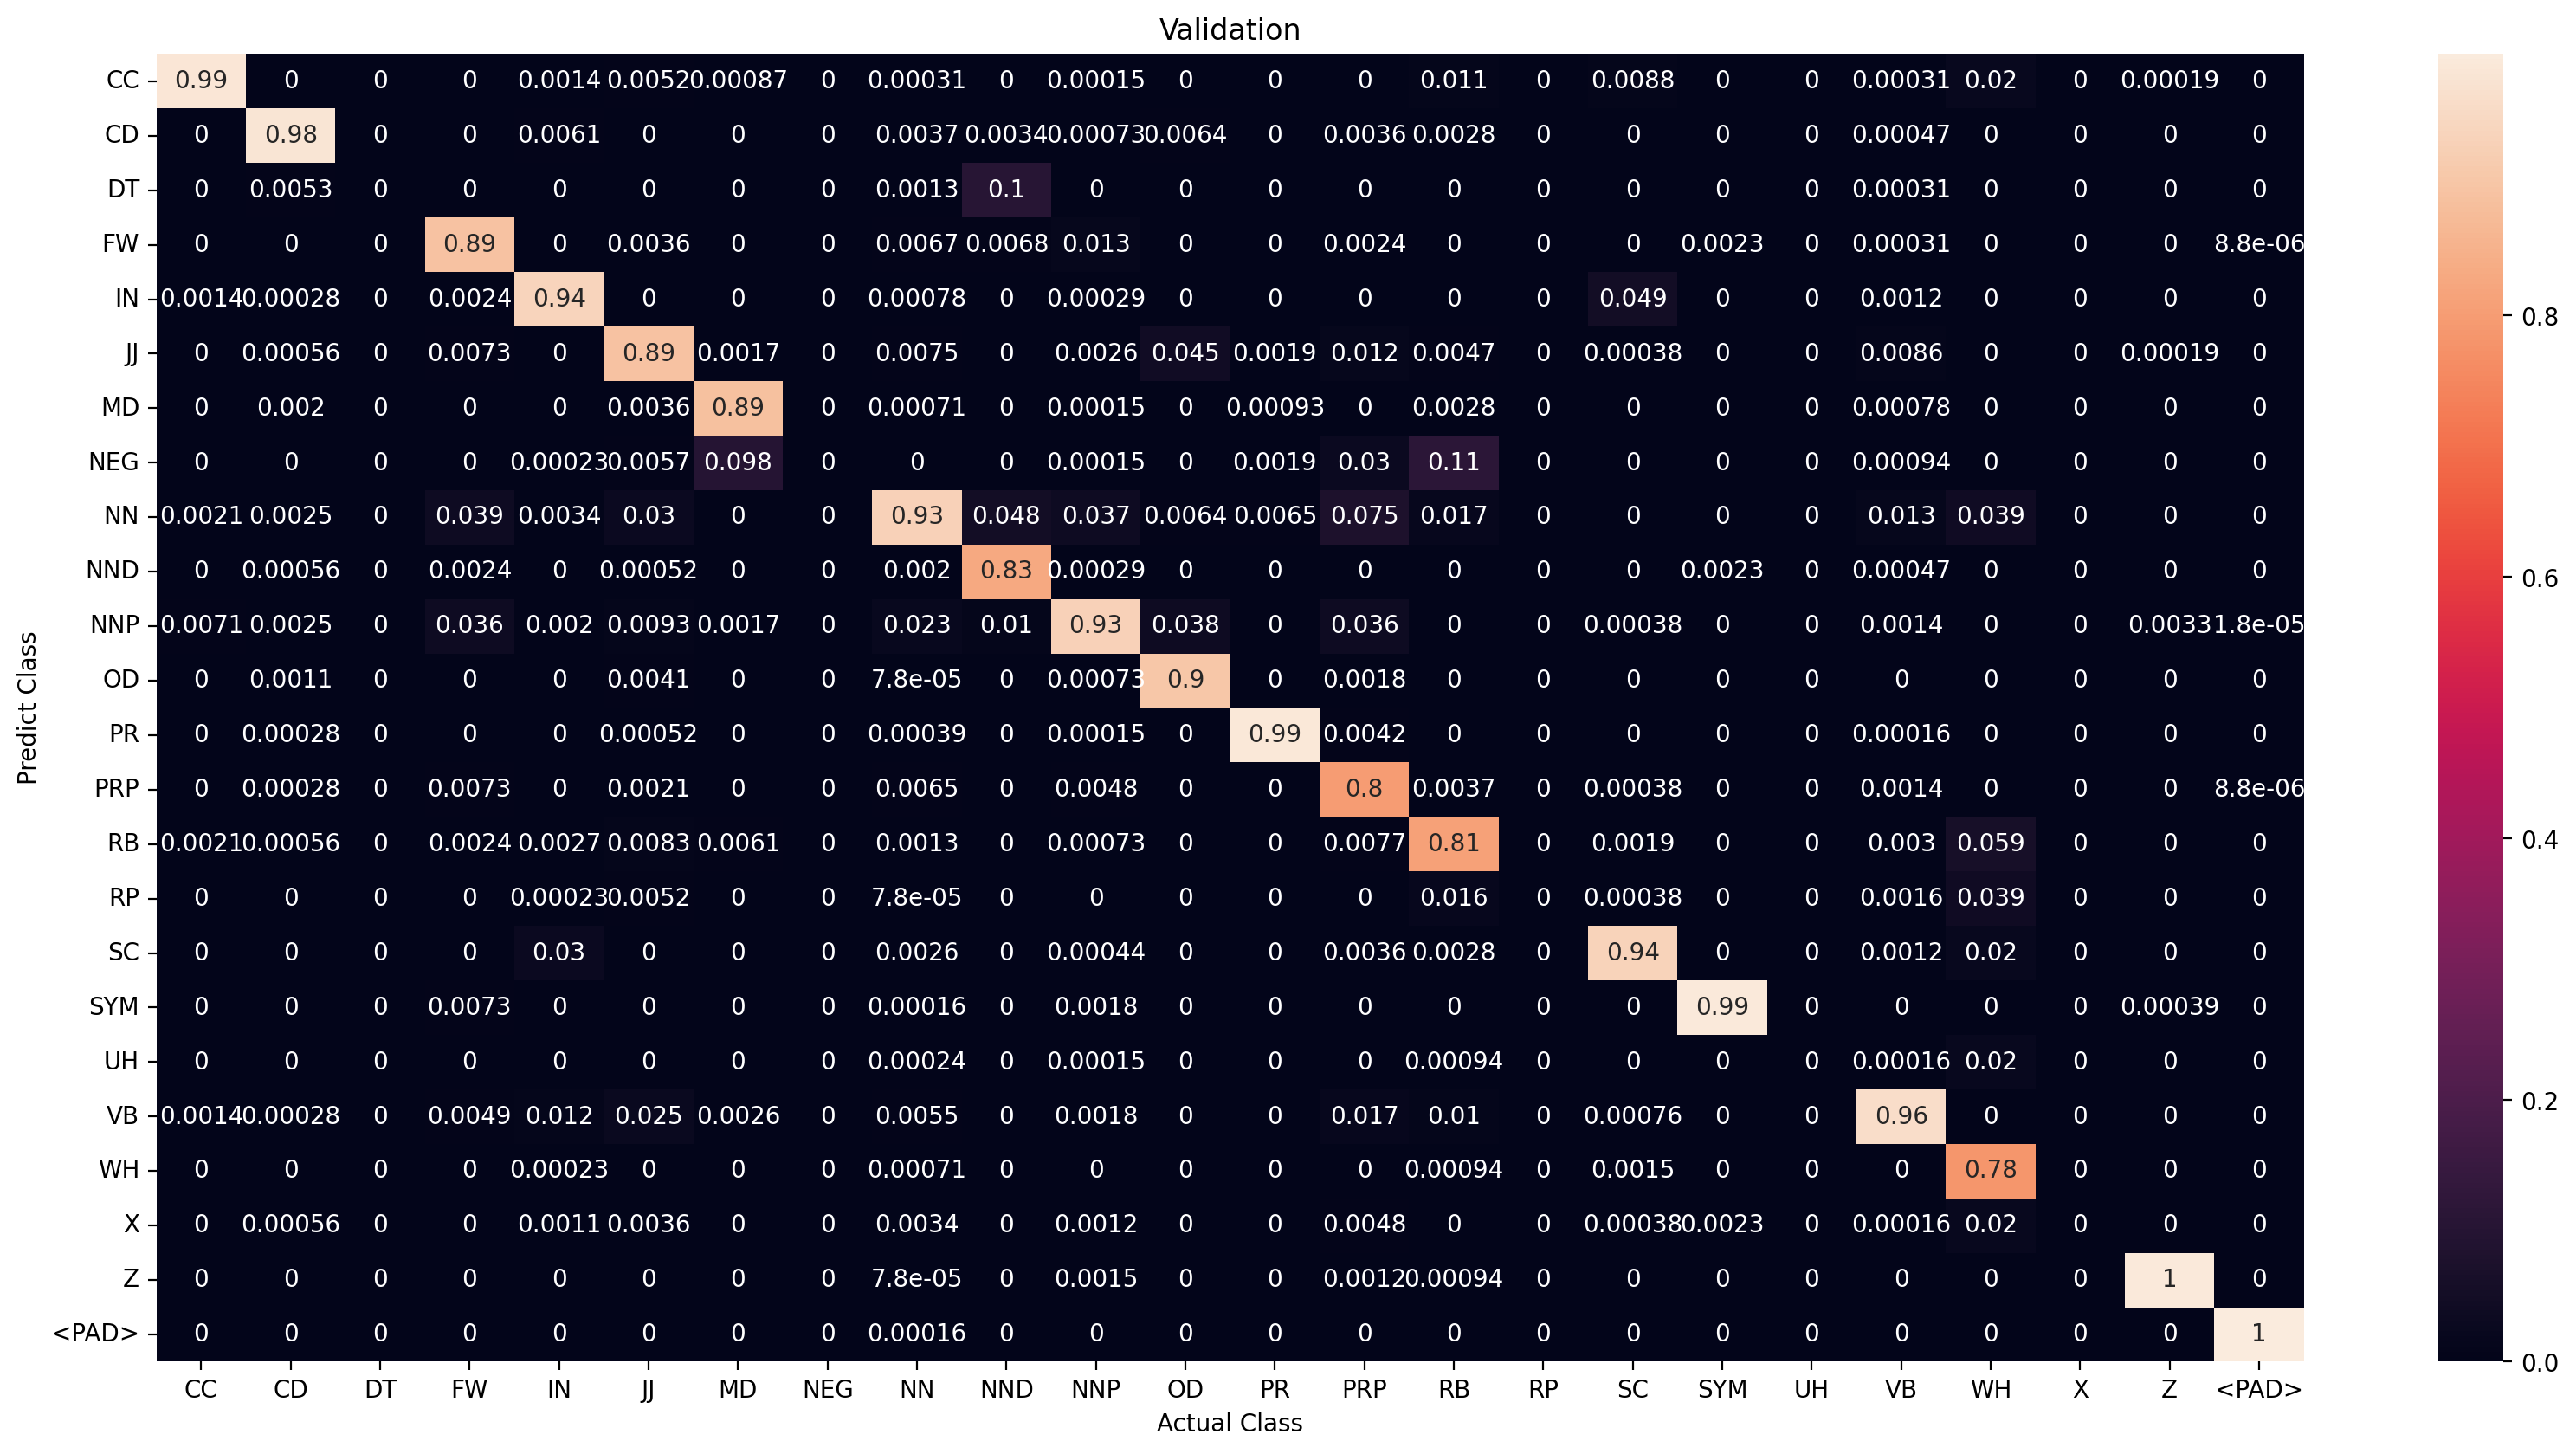

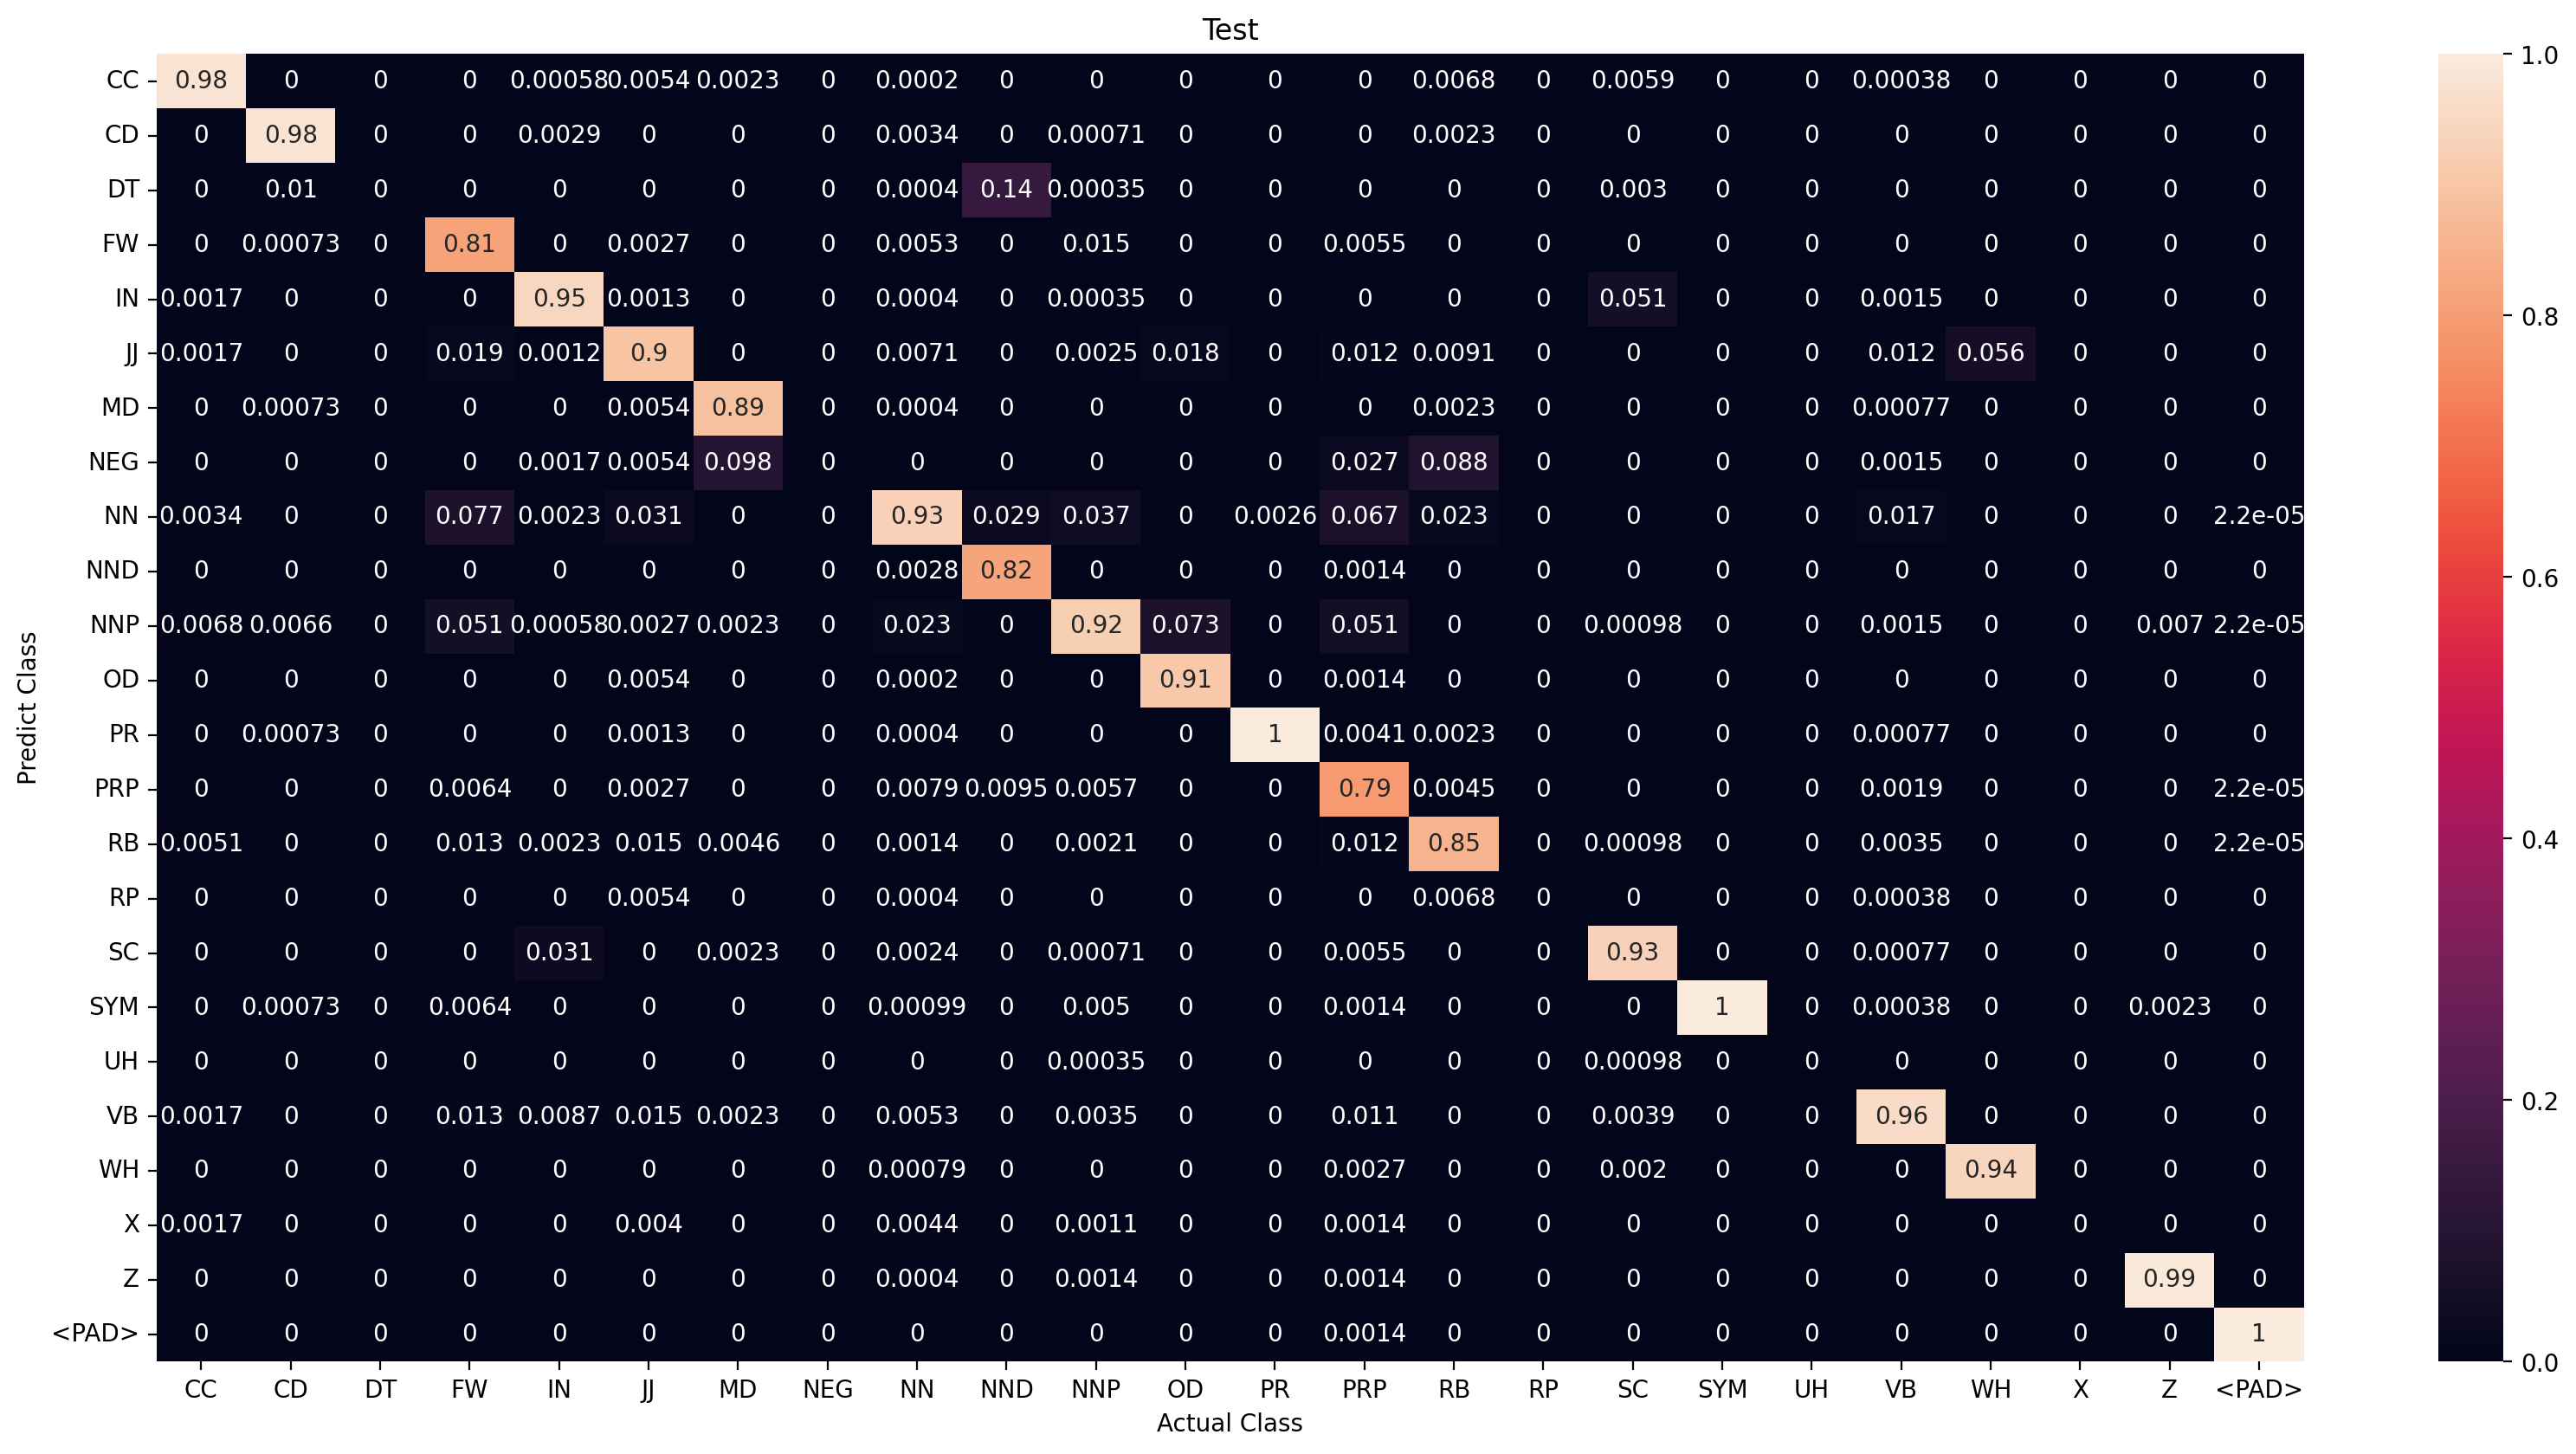

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5278       | CC    : 119      |
| CD    : 12862  | CD    : 12644      | CD    : 218      |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1265       | FW    : 340      |
| IN    : 15290  | IN    : 15125      | IN    : 165      |
| JJ    : 7025   | JJ    : 6557       | JJ    : 468      |
| MD    : 3798   | MD    : 3700       | MD    : 98       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43643      | NN    : 829      |
| NND   : 1033   | NND   : 926        | NND   : 107      |
| NNP   : 25007  | NNP   : 24230      | NNP   : 777      |
| OD    : 519    | OD    : 498        | OD    : 21       |
| PR    : 3880   | PR    : 3821       | PR    : 59       |
| PRP   : 5449   | PRP   : 5305       | PRP   : 144      |
| RB    : 3502   | RB    : 3223       | RB    : 279      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8, 19, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 10348
Wrong prediction            : 1623
Percentage correct oov pred : 86.44223540222204

Validation
Number OOV token            : 3190
Correct prediction          : 2329
Wrong prediction            : 861
Percentage correct oov pred : 73.00940438871474

Test
Number OOV token            : 1401
Correct prediction          : 998
Wrong prediction            : 403
Percentage correct oov pred : 71.23483226266953



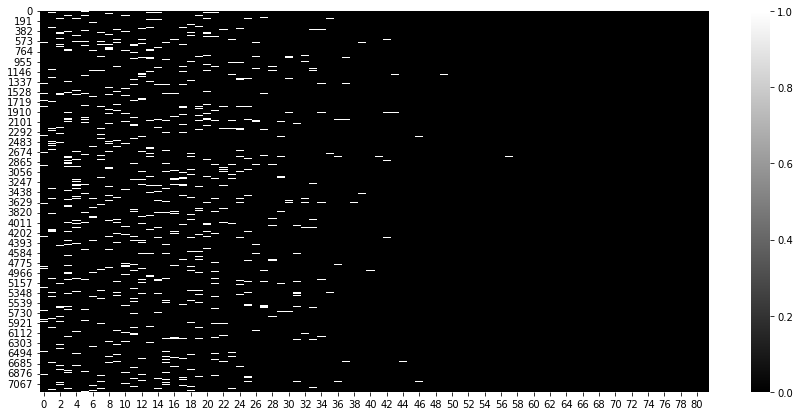

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

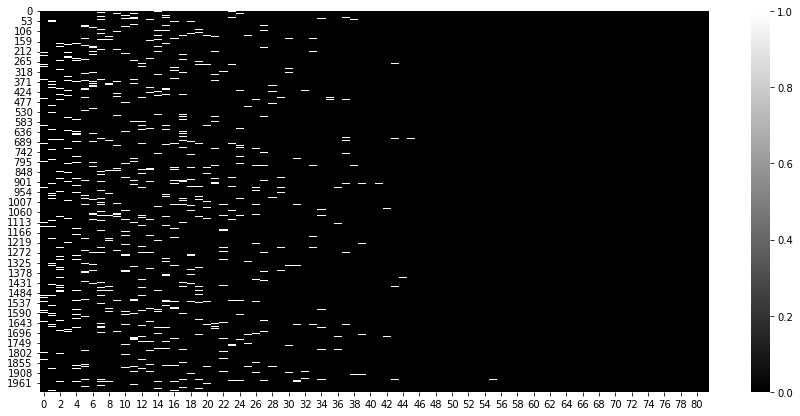

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

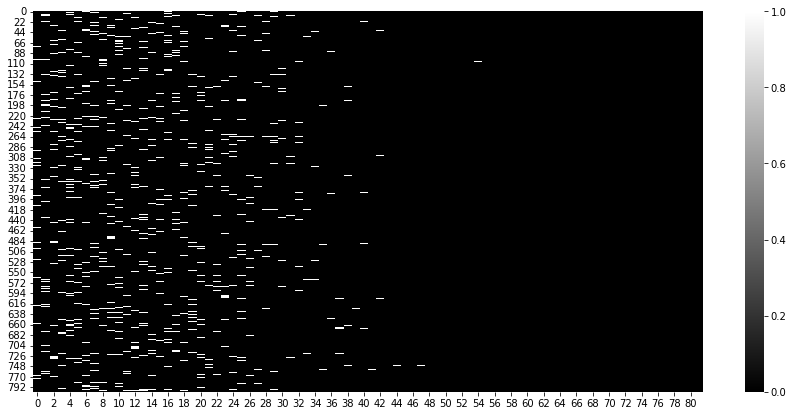

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);